In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
import tqdm as tqdm
#from tensorflow.keras import backend
from transformers import AutoImageProcessor, TFViTModel, ViTForImageClassification, TFSegformerForSemanticSegmentation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate, Flatten, Conv2D, Dropout,GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, roc_auc_score, auc

In [ ]:
folder = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe/tiles-128/'
df_labeled_128 = pd.read_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df_labeled-128.csv').dropna()

In [ ]:
df_labeled_128.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289883 entries, 0 to 289882
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  289883 non-null  object
 1   label       289883 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [ ]:
df_labeled_128.head(10)

,image_name,label
0,100694_sat_tile_0_0.jpg,agriculture_land
1,100694_sat_tile_0_1.jpg,agriculture_land
2,100694_sat_tile_0_10.jpg,agriculture_land
3,100694_sat_tile_0_11.jpg,agriculture_land
4,100694_sat_tile_0_12.jpg,agriculture_land
5,100694_sat_tile_0_13.jpg,agriculture_land
6,100694_sat_tile_0_14.jpg,agriculture_land
7,100694_sat_tile_0_15.jpg,agriculture_land
8,100694_sat_tile_0_16.jpg,agriculture_land
9,100694_sat_tile_0_17.jpg,agriculture_land


Vamos a eliminar los elementos etiquetados como 'unknown' ya que en el anterior modelo vimos que no aportan y pueden ser un handicap para el entrenamiento.

In [ ]:
df_labeled_128 = df_labeled_128.drop(df_labeled_128[df_labeled_128['label']  == 'unknown'].index)
df_labeled_128.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289730 entries, 0 to 289882
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  289730 non-null  object
 1   label       289730 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


Para entrenar el modelo binario, transformaremos todas las etiquetas que no sean 'agriculture_land' a 'No agriculture'

In [ ]:
for index, row in df_labeled_128.iterrows():
    if row['label'] != 'agriculture_land':
        df_labeled_128.at[index, 'label'] = "No agriculture"

print(df_labeled_128)

                      image_name             label
0        100694_sat_tile_0_0.jpg  agriculture_land
1        100694_sat_tile_0_1.jpg  agriculture_land
2       100694_sat_tile_0_10.jpg  agriculture_land
3       100694_sat_tile_0_11.jpg  agriculture_land
4       100694_sat_tile_0_12.jpg  agriculture_land
...                          ...               ...
289878   998002_sat_tile_9_5.jpg    No agriculture
289879   998002_sat_tile_9_6.jpg    No agriculture
289880   998002_sat_tile_9_7.jpg    No agriculture
289881   998002_sat_tile_9_8.jpg    No agriculture
289882   998002_sat_tile_9_9.jpg    No agriculture

[289730 rows x 2 columns]


In [ ]:
df_labeled_128.tail(10)

,image_name,label
289873,998002_sat_tile_9_17.jpg,agriculture_land
289874,998002_sat_tile_9_18.jpg,agriculture_land
289875,998002_sat_tile_9_2.jpg,No agriculture
289876,998002_sat_tile_9_3.jpg,No agriculture
289877,998002_sat_tile_9_4.jpg,No agriculture
289878,998002_sat_tile_9_5.jpg,No agriculture
289879,998002_sat_tile_9_6.jpg,No agriculture
289880,998002_sat_tile_9_7.jpg,No agriculture
289881,998002_sat_tile_9_8.jpg,No agriculture
289882,998002_sat_tile_9_9.jpg,No agriculture


In [ ]:
df_labeled_128.to_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df-128_binary_label.csv', index=False)

In [ ]:
df_binary = pd.read_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df-128_binary_label.csv').dropna()

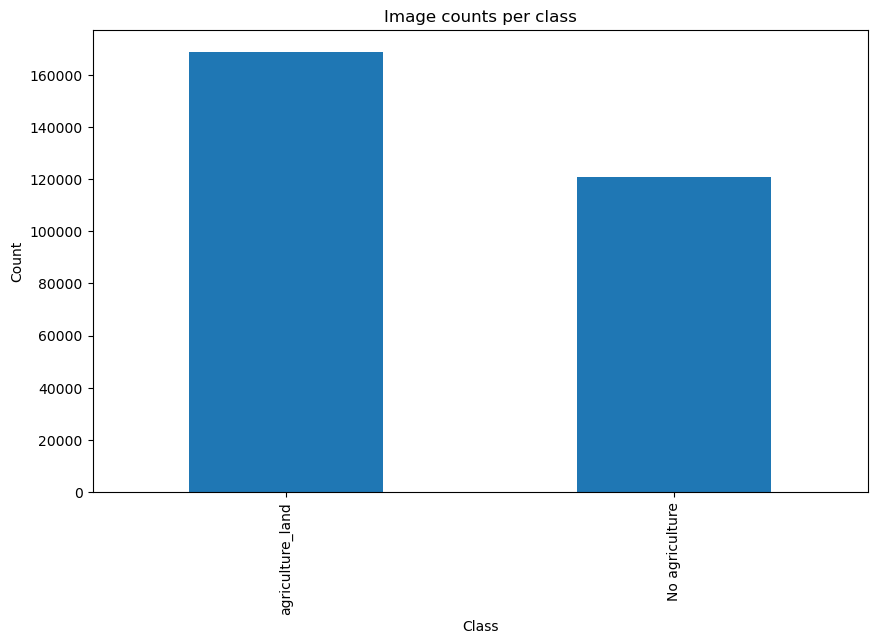

agriculture_land    168810
No agriculture      120920
Name: label, dtype: int64


In [ ]:
class_counts = df_binary['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Image counts per class')
plt.xticks(range(len(class_counts.index)), class_counts.index)
plt.show()

print(class_counts)

Por razones de memoria, entrenaremos con un máximo de 50.000 muestras, balanceadas, que deberán ser 25.000 de cada clase

In [ ]:
cut_number = 50000
classes = df_binary['label'].unique()
df_small_binary = pd.DataFrame(columns=['image_name', 'label'])

for class_name in classes:
    class_samples = df_binary[df_binary['label'] == class_name]
    # Number of samples per class
    num_samples = min(cut_number // len(classes), len(class_samples))
    # Randomly undersampled balanced
    class_samples_balanced = resample(
        class_samples,
        replace = False,
        n_samples = num_samples,
        random_state = 42
    )
    df_small_binary = df_small_binary.append(class_samples_balanced, ignore_index=True)

# Randomly shuffled
df_small_binary = df_small_binary.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\Conaf\AppData\Local\Temp\ipykernel_14356\2706801204.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_small_binary = df_small_binary.append(class_samples_balanced, ignore_index=True)


In [ ]:
df_small_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  50000 non-null  object
 1   label       50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


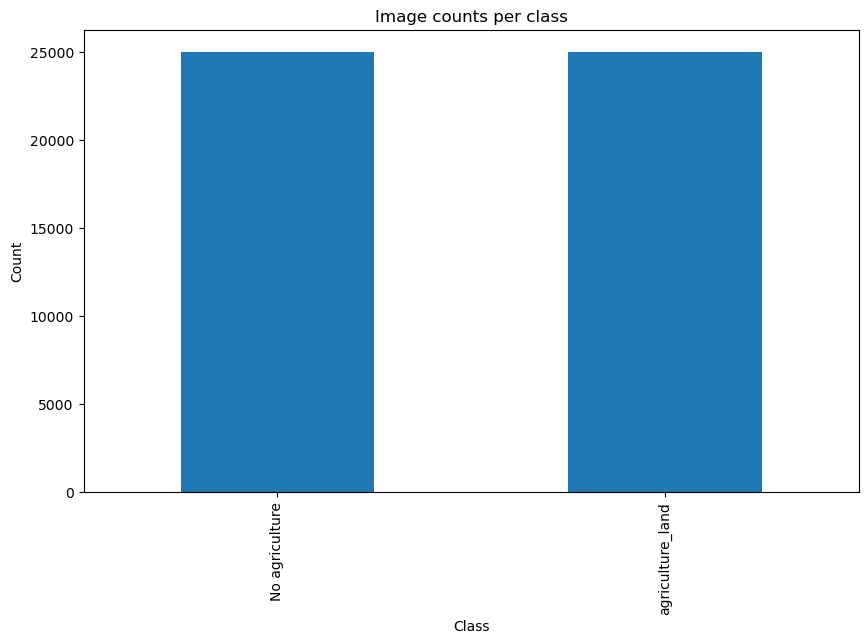

No agriculture      25000
agriculture_land    25000
Name: label, dtype: int64


In [ ]:
class_counts = df_small_binary['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Image counts per class')
plt.xticks(range(len(class_counts.index)), class_counts.index)
plt.show()

print(class_counts)

In [ ]:
#Guardamos el subset para poder utilizarlo más adelante
df_small_binary.to_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df-128_small_binary_label.csv', index=False)

In [ ]:
df_small_binary = pd.read_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df-128_small_binary_label.csv').dropna()

In [ ]:
df_small_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  50000 non-null  object
 1   label       50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Debemos realizar el pre-procesado de las imágenes de nuevo, de la misma manera que lo hicimos para el modelo multiclase, ya que el subset de imágenes, al ser tomadas de forma aleatoria, puede no ser el mismo.
La función de pre-procesado será la misma:

In [ ]:
from tqdm import tqdm

# Process and load images

def load_process_images(folder, df, size=128, batch_size=32):
    width = size
    height = size

    image_files = df['image_name'].tolist()

    # Initialize list to store image data
    images = []

    # Loop through the image files
    for start_idx in tqdm(range(0, len(image_files), batch_size), desc="Processing..."):
        #print(image_file)

        end_idx = start_idx + batch_size
        batch_files = image_files[start_idx:end_idx]

        batch_images = []
        for image_file in batch_files:

            # Construct the full file paths
            image_path = os.path.join(folder, image_file)

            # Load the image
            image = cv2.imread(image_path)
            # Check if the image is None
            if image is None:
                print(f"Error loading image: {image_file}")
                continue  # Skip this image

            # Resize the image
            image = cv2.resize(image, (width, height))

            # Normalize the image to values between 0 and 1
            image = image.astype(np.float32) / 255.0
            batch_images.append(image)
        # Append the image a to its list
        images.extend(batch_images)

    # Convert the lists of image to NumPy arrays
    images = np.array(images)

    return images

In [ ]:
images = load_process_images(folder, df=df_small_binary)

Processing...: 100%|██████████| 1563/1563 [00:36<00:00, 43.07it/s]


In [ ]:
# Guardamos en un archivo NumPy comprimido
np.savez_compressed('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_small_binary.npz', images=images)

In [ ]:
# Cargamos los datos
loaded_data = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_small_binary.npz')

loaded_images = loaded_data['images']

In [ ]:
y = df_small_binary['label'].values

In [ ]:
print(y)

['No agriculture' 'agriculture_land' 'agriculture_land' ...
 'No agriculture' 'agriculture_land' 'agriculture_land']


A partir de aquí, la preparación para el entrenamiento es la misma, label encoder, división de datos y extracción de embeddings con ViT.

In [ ]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded, num_classes=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(loaded_images, y_one_hot, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
modelViTClasif = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [ ]:
from tqdm import tqdm

embeddings_train = []
filtered_labels_train = []
for image, label in tqdm(zip(X_train, y_train), desc="Processing..."):
    if np.isnan(image).any() or np.isinf(image).any():
        print(f"Skipping image due to NaN or Infinity values.")
        continue
    inputs = image_processor(image, return_tensors='tf', do_rescale=False)
    outputs = modelViTClasif(**inputs)
    last_hidden_states = outputs.last_hidden_state
    embedding = tf.reduce_mean(last_hidden_states, axis=1)
    if np.isnan(embedding).any() or np.isinf(embedding).any():
        print(f"Skipping image due to NaN or Infinity values in embedding.")
        continue
    embeddings_train.append(embedding.numpy())
    filtered_labels_train.append(label)

X_emb_img_train = np.vstack(embeddings_train)
y_train_filtered = np.array(filtered_labels_train)

Processing...: 36125it [3:59:13,  2.52it/s]


In [ ]:
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_train_small_binary.npy', X_emb_img_train)
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_train_filtered_binary.npy', y_train_filtered)

In [ ]:
from tqdm import tqdm

embeddings_val = []
filtered_labels_val = []
for image, label in tqdm(zip(X_val, y_val), desc="Processing..."):
    if np.isnan(image).any() or np.isinf(image).any():
        print(f"Skipping image due to NaN or Infinity values.")
        continue
    inputs = image_processor(image, return_tensors='tf', do_rescale=False)
    outputs = modelViTClasif(**inputs)
    last_hidden_states = outputs.last_hidden_state
    embedding = tf.reduce_mean(last_hidden_states, axis=1)
    if np.isnan(embedding).any() or np.isinf(embedding).any():
        print(f"Skipping image due to NaN or Infinity values in embedding.")
        continue
    embeddings_val.append(embedding.numpy())
    filtered_labels_val.append(label)

X_emb_img_val = np.vstack(embeddings_val)
y_val_filtered = np.array(filtered_labels_val)

Processing...: 6375it [43:14,  2.46it/s]


In [ ]:
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_val_small_binary.npy', X_emb_img_val)
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_val_filtered_binary.npy', y_val_filtered)

In [ ]:
from tqdm import tqdm

embeddings_test = []
filtered_labels_test = []
for image, label in tqdm(zip(X_test, y_test), desc="Processing..."):
    if np.isnan(image).any() or np.isinf(image).any():
        print(f"Skipping image due to NaN or Infinity values.")
        continue
    inputs = image_processor(image, return_tensors='tf', do_rescale=False)
    outputs = modelViTClasif(**inputs)
    last_hidden_states = outputs.last_hidden_state
    embedding = tf.reduce_mean(last_hidden_states, axis=1)
    if np.isnan(embedding).any() or np.isinf(embedding).any():
        print(f"Skipping image due to NaN or Infinity values in embedding.")
        continue
    embeddings_test.append(embedding.numpy())
    filtered_labels_test.append(label)

X_emb_img_test = np.vstack(embeddings_test)
y_test_filtered = np.array(filtered_labels_test)

Processing...: 7500it [50:47,  2.46it/s]


In [ ]:
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_test_small_binary.npy', X_emb_img_test)
np.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_test_filtered_binary.npy', y_test_filtered)

In [ ]:
embeddings_train = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_train_small_binary.npy')
y_train_filtered = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_train_filtered_binary.npy')
embeddings_val = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_val_small_binary.npy')
y_val_filtered = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_val_filtered_binary.npy')
embeddings_test = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/embeddings_test_small_binary.npy')
y_test_filtered = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/y_test_filtered_binary.npy')

In [ ]:
print(f"embeddings_train: {embeddings_train.shape}")
print(f"y_train_filtered: {y_train_filtered.shape}")
print(f"embeddings_val: {embeddings_val.shape}")
print(f"y_val_filtered: {y_val_filtered.shape}")
print(f"embeddings_test: {embeddings_test.shape}")
print(f"y_test_filtered: {y_test_filtered.shape}")

embeddings_train: (36125, 768)
y_train_filtered: (36125, 2)
embeddings_val: (6375, 768)
y_val_filtered: (6375, 2)
embeddings_test: (7500, 768)
y_test_filtered: (7500, 2)


In [ ]:
# Random Search
inputs = Input(shape=(embeddings_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
predictions = Dense(2, activation='softmax')(x)

modelViT = Model(inputs, predictions)


param_dist = {
    'learning_rate': np.random.uniform(0.0001, 0.1, size=15),
    'batch_size': [16, 32, 64, 128],
    'num_hidden_units': [64, 128, 256],
    'dropout_rate': np.random.uniform(0.2, 0.5, size=10)
}

num_trials = 60
epochs = 20
best_hyperparameters = None
best_validation_accuracy = 0.0

for _ in range(num_trials):
  sampled_params = {
      'learning_rate': np.random.choice(param_dist['learning_rate']),
      'batch_size': np.random.choice(param_dist['batch_size']),
      'num_hidden_units': np.random.choice(param_dist['num_hidden_units']),
      'dropout_rate': np.random.choice(param_dist['dropout_rate'])
  }

  modelViT.compile(optimizer=Adam(learning_rate=sampled_params['learning_rate']), loss='categorical_crossentropy', metrics=['accuracy'])
  H = modelViT.fit(embeddings_train, y_train_filtered, validation_data=(embeddings_val, y_val_filtered), epochs=epochs, batch_size=sampled_params['batch_size'])

  val_probs = modelViT.predict(embeddings_val)
  val_labels_pred = np.argmax(val_probs, axis=1)
  y_val_filtered__ = np.argmax(y_val_filtered, axis=1)
  val_accuracy =accuracy_score(y_val_filtered__, val_labels_pred)

  if val_accuracy > best_validation_accuracy:
    best_validation_accuracy = val_accuracy
    best_hyperparameters = sampled_params

print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_validation_accuracy)

Epoch 1/20
565/565 [==============================] - 1s 2ms/step - loss: 0.3605 - accuracy: 0.8423 - val_loss: 0.3205 - val_accuracy: 0.8536
Epoch 2/20
565/565 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.8634 - val_loss: 0.3018 - val_accuracy: 0.8657
Epoch 3/20
565/565 [==============================] - 1s 2ms/step - loss: 0.3007 - accuracy: 0.8689 - val_loss: 0.3276 - val_accuracy: 0.8662
Epoch 4/20
565/565 [==============================] - 1s 2ms/step - loss: 0.2813 - accuracy: 0.8773 - val_loss: 0.2989 - val_accuracy: 0.8753
Epoch 5/20
565/565 [==============================] - 1s 2ms/step - loss: 0.2859 - accuracy: 0.8780 - val_loss: 0.3102 - val_accuracy: 0.8659
Epoch 6/20
565/565 [==============================] - 1s 2ms/step - loss: 0.2780 - accuracy: 0.8776 - val_loss: 0.3159 - val_accuracy: 0.8700
Epoch 7/20
565/565 [==============================] - 1s 2ms/step - loss: 0.2714 - accuracy: 0.8831 - val_loss: 0.3168 - val_accuracy: 0.8678
Epoch 

In [ ]:
best_num_hidden_units = 256
best_dropout_rate = 0.36875448592721993
inputs = Input(shape=(embeddings_train.shape[1],))
x = Dense(best_num_hidden_units, activation='relu')(inputs)
dropout_layer = Dropout(rate=best_dropout_rate)(x)

# Define the output layer (assuming it's a classification task)
predictions = Dense(2, activation='softmax')(dropout_layer)

# Create the functional model
modelViT = Model(inputs, predictions)

In [ ]:
epochs = 10000
batch_size = 128


# Drop learning rate scheduler
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate

initial_learning_rate = 0.0456616742520753
epochs_drop = 90
drop_rate = 0.8
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)


modelViT.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
H = modelViT.fit(embeddings_train, y_train_filtered, validation_data=(embeddings_val, y_val_filtered), epochs=epochs, batch_size=batch_size, callbacks=[lr_scheduler, early_stopping])

Epoch 1/10000
283/283 [==============================] - 2s 4ms/step - loss: 0.4196 - accuracy: 0.8228 - val_loss: 0.3250 - val_accuracy: 0.8533 - lr: 0.0457
Epoch 2/10000
283/283 [==============================] - 1s 4ms/step - loss: 0.3523 - accuracy: 0.8394 - val_loss: 0.3087 - val_accuracy: 0.8634 - lr: 0.0457
Epoch 3/10000
283/283 [==============================] - 1s 4ms/step - loss: 0.3476 - accuracy: 0.8396 - val_loss: 0.3287 - val_accuracy: 0.8613 - lr: 0.0457
Epoch 4/10000
283/283 [==============================] - 1s 4ms/step - loss: 0.3363 - accuracy: 0.8491 - val_loss: 0.3039 - val_accuracy: 0.8557 - lr: 0.0457
Epoch 5/10000
283/283 [==============================] - 1s 4ms/step - loss: 0.3382 - accuracy: 0.8449 - val_loss: 0.3199 - val_accuracy: 0.8675 - lr: 0.0457
Epoch 6/10000
283/283 [==============================] - 1s 4ms/step - loss: 0.3279 - accuracy: 0.8491 - val_loss: 0.2986 - val_accuracy: 0.8678 - lr: 0.0457
Epoch 7/10000
283/283 [=============================

In [ ]:
print("Evaluación del modelo...")
y_pred_modelViT_val = modelViT.predict(embeddings_val, batch_size=128)
print(classification_report(y_val_filtered.argmax(axis=1), y_pred_modelViT_val.argmax(axis=1), zero_division=1))

y_pred_modelViT_test = modelViT.predict(embeddings_test, batch_size=128)
print(classification_report(y_test_filtered.argmax(axis=1), y_pred_modelViT_test.argmax(axis=1), zero_division=1))

Evaluación del modelo...
50/50 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3200
           1       0.90      0.82      0.86      3175

    accuracy                           0.87      6375
   macro avg       0.87      0.87      0.87      6375
weighted avg       0.87      0.87      0.87      6375

59/59 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3743
           1       0.89      0.81      0.85      3757

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



In [ ]:
#  ROC (Receiving Operating Characteristic Curve)
# ROC-AUC (Area Under Curve de esa curva)

fpr, tpr, thresholds = roc_curve(y_val_filtered[:, 1], y_pred_modelViT_val[:, 1])
roc_auc = roc_auc_score(y_val_filtered[:, 1], y_pred_modelViT_val[:, 1])

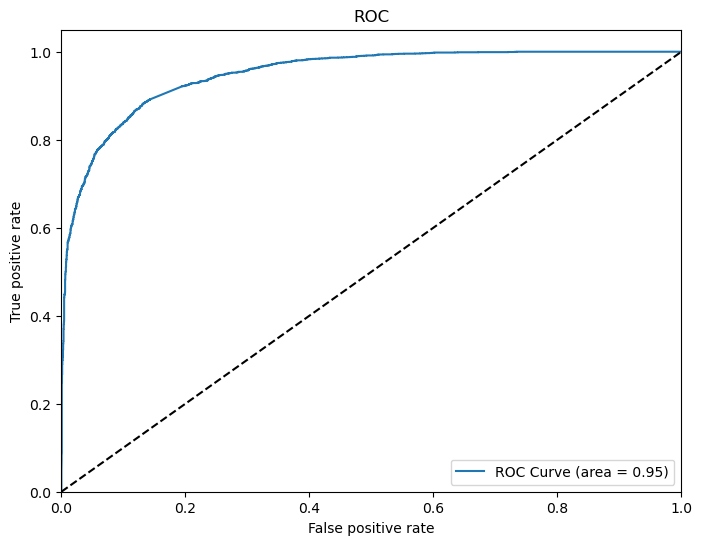

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
modelViT.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/model_vit_128_2classes.keras')
modelViT.save('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/model_vit_128_2classes.h5')

Los resultados obtenidos con el modelo binario, son muy superiores a los obtenidos en el multiclase, aunque existen diferencias que favorecen estos resultados, como, el haber pasado de unas 7.000 muestras por clase a tener ahora 25.000 para cada una de las dos clases. Además, aquí hemos eliminado los 'unknown'.